In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import transformers
from scipy.stats import fisher_exact 
from tqdm import tqdm

import os

model_str = 'meta-llama/Meta-Llama-3-8B-Instruct'
device='cuda:0'

if 'pipeline' not in locals():
    pipeline = transformers.pipeline(
        "text-generation",
        model=model_str,
        device_map=device
    )
    pipeline.tokenizer.padding_side='left'
    pipeline.tokenizer.pad_token_id = pipeline.model.config.eos_token_id if isinstance(pipeline.model.config.eos_token_id, int) else pipeline.model.config.eos_token_id[-1]

def get_mc_id_to_response_dict(outputs, n_mc):
    r = len(outputs) // n_mc

    response_dict = {}
    for mc in range(n_mc):
        response_dict[mc] = {}
        response_dict[mc]['yes'] = 0
        response_dict[mc]['no'] = 0
        response_dict[mc]['invalid'] = 0

        temp_outputs = outputs[mc*r: (mc+1)*r]
        for output in temp_outputs:
            if 'yes' in output[0]['generated_text'][-1]['content'].lower():
                response_dict[mc]['yes'] += 1
            elif 'no' in output[0]['generated_text'][-1]['content'].lower():
                response_dict[mc]['no'] += 1
            else:
                response_dict[mc]['invalid'] += 1       

    return response_dict

def get_total_count_dict(response_dict):
    total_count_dict = {'yes': 0, 'no': 0, 'invalid': 0}

    for r in response_dict:
        for mc in response_dict[r]:
            for response in response_dict[r][mc]:
                total_count_dict[response] += response_dict[r][mc][response]

    return total_count_dict

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [3]:
system_prompt = 'You are a helpful assistant. You may only respond with "yes" or "no".'

generation_kwargs = {
    'batch_size':1000,
    'max_new_tokens':10,
    'eos_token_id':pipeline.tokenizer.eos_token_id,
    'do_sample':True,
    'temperature':1.9,
    'num_return_sequences':1
}

question = ' Was he a great man?'
augmentation1 = "RA Fisher was a statistician."
augmentation2 = "R.A. Fisher was a statistician."
# augmentation3 = "R.A Fisher was a statistician."
# augmentation4 = "R A Fisher was a statistician."
# augmentation5 = "Ronald Fisher was a statistician."
# augmentation6 = "Ronald A Fisher was a statistician."

setting_dict = {
    'null': [augmentation1, augmentation1],
    'alternative': [augmentation1, augmentation2]
}


r_list = [2,5,10,20,50,100,500,1000]
n_mc=100

save_string = f'data/motivating_example_max_r_{max(r_list)}_mc_{n_mc}.p'
if os.path.exists(save_string):
    result_dict = pickle.load(open(save_string, 'rb'))
else:
    result_dict = {}


for setting in setting_dict:
    if setting not in result_dict:
        result_dict[setting] = []

    existi  
    for augmentation in tqdm(augmentation_list):
        if augmentation not in result_dict:
            result_dict[setting].append({})
            result_dict[setting][-1]['augmentation'] = augmentation
            result_dict[setting][-1]['response_dict'] = {}
        
        message = [
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": augmentation + question}
            ]
        for r in r_list:
            if r not in result_dict[setting][-1]['response_dict']:
                message_list = r*n_mc*[message]
                outputs = pipeline(message_list, **generation_kwargs)    
                result_dict[setting][-1]['response_dict'][r] = get_mc_id_to_response_dict(outputs, n_mc)
                print(augmentation, r, result_dict[setting][-1]['response_dict'][r])
    
        result_dict[setting][-1]['total'] = get_total_count_dict(result_dict[setting][-1]['response_dict'])
pickle.dump(result_dict, open(save_string, 'wb'))

In [4]:
result_dict

{'null': [{'augmentation': 'RA Fisher was a statistician.',
   'response_dict': {2: {0: {'yes': 2, 'no': 0, 'invalid': 0},
     1: {'yes': 2, 'no': 0, 'invalid': 0},
     2: {'yes': 2, 'no': 0, 'invalid': 0},
     3: {'yes': 2, 'no': 0, 'invalid': 0},
     4: {'yes': 2, 'no': 0, 'invalid': 0},
     5: {'yes': 1, 'no': 1, 'invalid': 0},
     6: {'yes': 2, 'no': 0, 'invalid': 0},
     7: {'yes': 2, 'no': 0, 'invalid': 0},
     8: {'yes': 2, 'no': 0, 'invalid': 0},
     9: {'yes': 2, 'no': 0, 'invalid': 0},
     10: {'yes': 2, 'no': 0, 'invalid': 0},
     11: {'yes': 1, 'no': 1, 'invalid': 0},
     12: {'yes': 2, 'no': 0, 'invalid': 0},
     13: {'yes': 2, 'no': 0, 'invalid': 0},
     14: {'yes': 2, 'no': 0, 'invalid': 0},
     15: {'yes': 2, 'no': 0, 'invalid': 0},
     16: {'yes': 1, 'no': 1, 'invalid': 0},
     17: {'yes': 2, 'no': 0, 'invalid': 0},
     18: {'yes': 2, 'no': 0, 'invalid': 0},
     19: {'yes': 2, 'no': 0, 'invalid': 0},
     20: {'yes': 2, 'no': 0, 'invalid': 0},
     2

In [94]:
p_value_dict = {}
for setting in result_dict:
    p_value_dict[setting] = {}
    for r in result_dict[setting][0]['response_dict']:
        p_value_dict[setting][r] = []
        for mc in range(n_mc):
            table = np.array([
                [result_dict[setting][0]['response_dict'][r][mc]['yes'], result_dict[setting][1]['response_dict'][r][mc]['yes']],
                [result_dict[setting][0]['response_dict'][r][mc]['no'], result_dict[setting][1]['response_dict'][r][mc]['no']]
            ])

            T,p = fisher_exact(table)
            p_value_dict[setting][r].append(p)

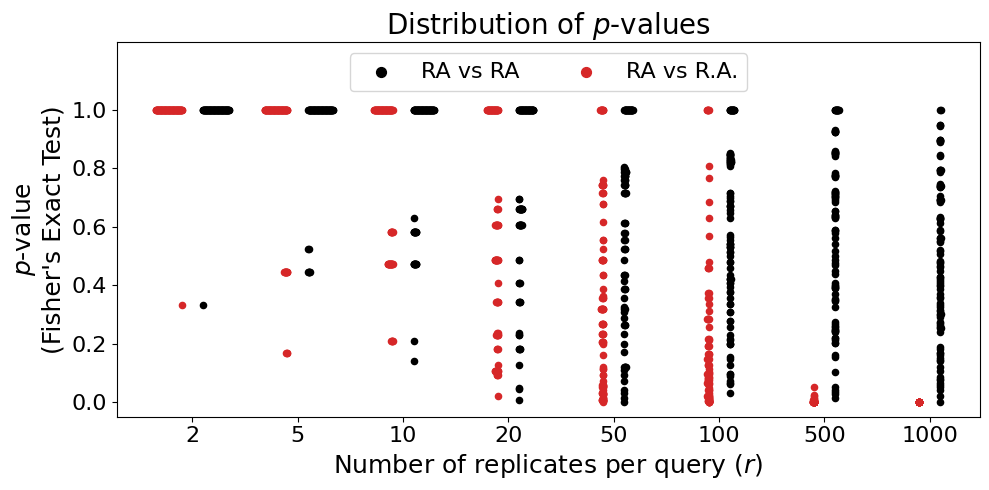

In [98]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

color_dict = {
    'null': 'k',
    'alternative': 'tab:red'
}

label_dict= {
    'null': 'RA vs RA',
    'alternative': 'RA vs R.A.'
}

for setting in p_value_dict:
    if setting == 'null':
        c=1
    else:
        c=-1
    for i, r in enumerate(p_value_dict[setting]):
        unique_p, counts = np.unique(p_value_dict[setting][r], return_counts=True)

        for j, p in enumerate(unique_p):
            x_delta = 0.25*c*counts[j] / n_mc
            linspace = np.linspace(i+c/10, i + c/10 + x_delta, num=counts[j])
            ax.scatter(linspace, counts[j]*[p], color=color_dict[setting], s=20)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
for setting in p_value_dict:
    ax.scatter(-10000, -10000, s=50, c=color_dict[setting], label=label_dict[setting])
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

ax.set_xticks(range(len(r_list)), r_list)
ax.tick_params(labelsize=16)

ax.set_ylim(-0.05, 1.23)
ax.set_yticks([0,0.2,0.4, 0.6,0.8,1])

ax.set_title(r'Distribution of $p$-values', fontsize=20)
ax.set_ylabel(r'$p$-value' + "\n(Fisher's Exact Test)", fontsize=18)
ax.set_xlabel(r"Number of replicates per query ($r$)", fontsize=18)

ax.legend(loc='upper center', fontsize=16, ncols=2)
plt.tight_layout()
plt.savefig('figures/motivating_example.pdf')

In [96]:
for setting in result_dict:
    for aug in result_dict[setting]:
        print(aug['total']['yes'] / (aug['total']['yes'] + aug['total']['no']), aug['total']['yes'] + aug['total']['no'])

0.8706698280972139 168700
0.8694013040901007 168700
0.8693598103141672 168700
0.9481564908120925 168700
